In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sonoma = pd.read_csv("../main_data/locale_specific_data/SonomaCountyData.csv")

### Summary

Data cleaning:
- drop unnecessary columns
- change index
- clean columns with .str(), .split(), .fillna(), .apply() [with context], 
- rename columns to combine with other datasets
- skip rows?

This data:
- WeekYear format for dates (mid 2000s - present)
- CountOf...
- intakes/outtakes statistics
- (Optional)

Observations:
- 884 breeds
- outcome_jurisdicition has inconsistent cities/towns (see below)

In [3]:
# replace column names: " " to "_" and change to lowercase
def remove_space(column_name):
    return column_name.lower().replace(' ','_')
sonoma = sonoma.rename(remove_space, axis = "columns")

# Only look at dogs
sonoma = sonoma.loc[sonoma.type == "DOG"]

# convert to datetime format
sonoma["intake_date"] = pd.to_datetime(sonoma["intake_date"])
sonoma["outcome_date"] = pd.to_datetime(sonoma["outcome_date"])

# "location" values are of the form zipcode(latitude,longitude)
# this function keeps only the zipcode of outcome jurisdiction
# there is already an "outcome_zip_code" column with float, I'm too lazy to modify it and will drop this column
def remove_lat_long(column_name):
    return str(column_name)[:5]
sonoma["zipcode"] = sonoma["location"].apply(remove_lat_long)

# outcome_jurisdicition has inconsistent cities/towns (see below)
def remove_ast(column_name):
    return str(column_name).replace("*","")
sonoma["outcome_jurisdiction"] = sonoma["outcome_jurisdiction"].apply(remove_ast)

In [4]:
sonoma.columns

Index(['name', 'type', 'breed', 'color', 'sex', 'size', 'date_of_birth',
       'impound_number', 'kennel_number', 'animal_id', 'intake_date',
       'outcome_date', 'days_in_shelter', 'intake_type', 'intake_subtype',
       'outcome_type', 'outcome_subtype', 'intake_condition',
       'outcome_condition', 'intake_jurisdiction', 'outcome_jurisdiction',
       'outcome_zip_code', 'location', 'count', 'zipcode'],
      dtype='object')

In [5]:
sonoma.intake_type.unique()

array(['TRANSFER', 'STRAY', 'OWNER SURRENDER', 'QUARANTINE',
       'ADOPTION RETURN', 'CONFISCATE', 'BORN HERE'], dtype=object)

In [6]:
# 1. Stray/Abandoned
# 2. Owner Surrender
# 3. Euthanasia Request
# 4. Public Assist (anything that involves intake for community (court ordered, police help, rabies quarantines)
# 5. Other/Transfers"

# transfer -> other
# stray -> stray_abandoned
# owner surrender -> owner_surrender
# quarantine -> public assist
# adoption return -> owner surrender
# confiscate -> public assist
# born here -> other

sonoma["stray_abandoned"] = 0
sonoma["owner_surrender"] = 0
sonoma["euthanasia"] = 0
sonoma["public_assist"] = 0
sonoma["other_i"] = 0

In [7]:
sonoma = sonoma.reset_index()

for index,row in sonoma.iterrows():
    if row["intake_type"] == "STRAY":
        sonoma.at[index,"stray_abandoned"] = 1
    elif row["intake_type"] == "OWNER SURRENDER" or row["intake_type"] == "ADOPTION RETURN":
        sonoma.at[index,"owner_surrender"] = 1
    elif row["intake_type"] == "QUARANTINE" or row["intake_type"] == "CONFISCATE":
        sonoma.at[index,"public_assist"] = 1
    else:
        sonoma.at[index,"other_i"] = 1


In [8]:
print(sum(sonoma["stray_abandoned"]))
print(sum(sonoma["owner_surrender"]))
print(sum(sonoma["euthanasia"]))
print(sum(sonoma["public_assist"]))
print(sum(sonoma["other_i"]))

11378
1803
0
2242
265


In [9]:
sonoma.outcome_type.unique()

array(['EUTHANIZE', 'ADOPTION', 'TRANSFER', 'RETURN TO OWNER', 'DIED',
       'ESCAPED/STOLEN', 'DISPOSAL', nan, 'RTOS', 'VET'], dtype=object)

In [10]:
# 1. Return to Owner
# 2. Adoption
# 3. Euthanasia
# 4. Unintended (Missing, Stolen, Died, Lost)
# 5. Other/Transfer

# EUTHANIZE -> euthanisasia
# ADOPTION -> adoption
# TRANSFER -> other
# RETURN TO OWNER -> return to owner
# DIED -> unintended
# ESCAPED/STOLEN -> unintended
# DISPOSAL -> unintended
# nan -> other
# RTOS -> return to owner
# VET -> other

sonoma["euthanised"] = 0
sonoma["adoption"] = 0
sonoma["return_to_owner"] = 0
sonoma["unintended"] = 0
sonoma["other_o"] = 0

In [11]:
sonoma = sonoma.reset_index()

for index,row in sonoma.iterrows():
    if row["outcome_type"] == "EUTHANIZE":
        sonoma.at[index,"euthanised"] = 1
    elif row["outcome_type"] == "ADOPTION":
        sonoma.at[index,"adoption"] = 1
    elif row["outcome_type"] == "RETURN TO OWNER" or row["outcome_type"] == "RTOS":
        sonoma.at[index,"return_to_owner"] = 1
    elif row["outcome_type"] == "DIED" or row["outcome_type"] == "ESCAPED/STOLEN" or row["outcome_type"] == "DISPOSAL":
        sonoma.at[index,"unintended"] = 1
    else:
        sonoma.at[index,"other_o"] = 1

In [12]:
print(sum(sonoma["euthanised"]))
print(sum(sonoma["adoption"]))
print(sum(sonoma["return_to_owner"]))
print(sum(sonoma["unintended"]))
print(sum(sonoma["other_o"]))

1729
3615
7851
76
2417


In [13]:
# replace values with np.nan
sonoma = sonoma.replace({np.nan: np.nan,"NaN": np.nan, "nan": np.nan, "Unknown": np.nan,"UNKNOWN":np.nan})

In [14]:
# range of dates
date_min = min(min(sonoma["intake_date"]),min(sonoma["outcome_date"]))
date_max = max(max(sonoma["intake_date"]),max(sonoma["outcome_date"]))
idx = pd.date_range(date_min,date_max)

In [15]:
# range of dates
date_min = min(min(sonoma["intake_date"]),min(sonoma["outcome_date"]))
date_max = max(max(sonoma["intake_date"]),max(sonoma["outcome_date"]))
idx = pd.date_range(date_min,date_max)

# create a DF with date-intakes and date-outcomes via value_counts
intake_df = pd.DataFrame(sonoma["intake_date"].value_counts().reset_index()).sort_values(by="intake_date")
intake_series = pd.Series(dict(zip(intake_df["intake_date"], intake_df["count"])))
outcome_df = pd.DataFrame(sonoma["outcome_date"].value_counts().reset_index()).sort_values(by="outcome_date")
outcome_series = pd.Series(dict(zip(outcome_df["outcome_date"], intake_df["count"])))

# fill in missing date rows with 0
intake_series.index = pd.DatetimeIndex(intake_series.index)
intake_series = intake_series.reindex(idx,fill_value=0)
outcome_series.index = pd.DatetimeIndex(outcome_series.index)
outcome_series = outcome_series.reindex(idx,fill_value=0)

# initialise DF
sonoma_count = pd.DataFrame({'date':idx,'intakes': intake_series.values, 'outcomes':outcome_series.values})

# create intake series that fill missing date rows with 0
def create_series(col):
    tmp_df = pd.DataFrame(sonoma.groupby(['intake_date',col])[col].value_counts().reset_index()).sort_values(by='intake_date')
    tmp_df = tmp_df[tmp_df[col] != 0]
    tmp_df = tmp_df.drop(columns=col)    
    
    tmp_series = pd.Series(dict(zip(tmp_df['intake_date'], tmp_df['count'])))
    tmp_series.index = pd.DatetimeIndex(tmp_series.index)
    tmp_series = tmp_series.reindex(idx,fill_value=0)

    return tmp_series

# create a new dataframe consisting of "date", "# of intakes", "# of outcomes", "intake_type", "outcome_type"
intake_list = ["stray_abandoned","owner_surrender","euthanasia","public_assist","other_i"]
outcome_list = ["euthanised","adoption","return_to_owner","unintended","other_o"]

# insert new columns in sonoma_count
for intake in intake_list:
    intake_series = create_series(intake)
    sonoma_count.insert(len(sonoma_count.columns),"intake_" + intake,list(intake_series),True)
    
for outcome in outcome_list:
    outcome_series = create_series(outcome)
    sonoma_count.insert(len(sonoma_count.columns),"outcome_" + outcome,list(outcome_series),True)


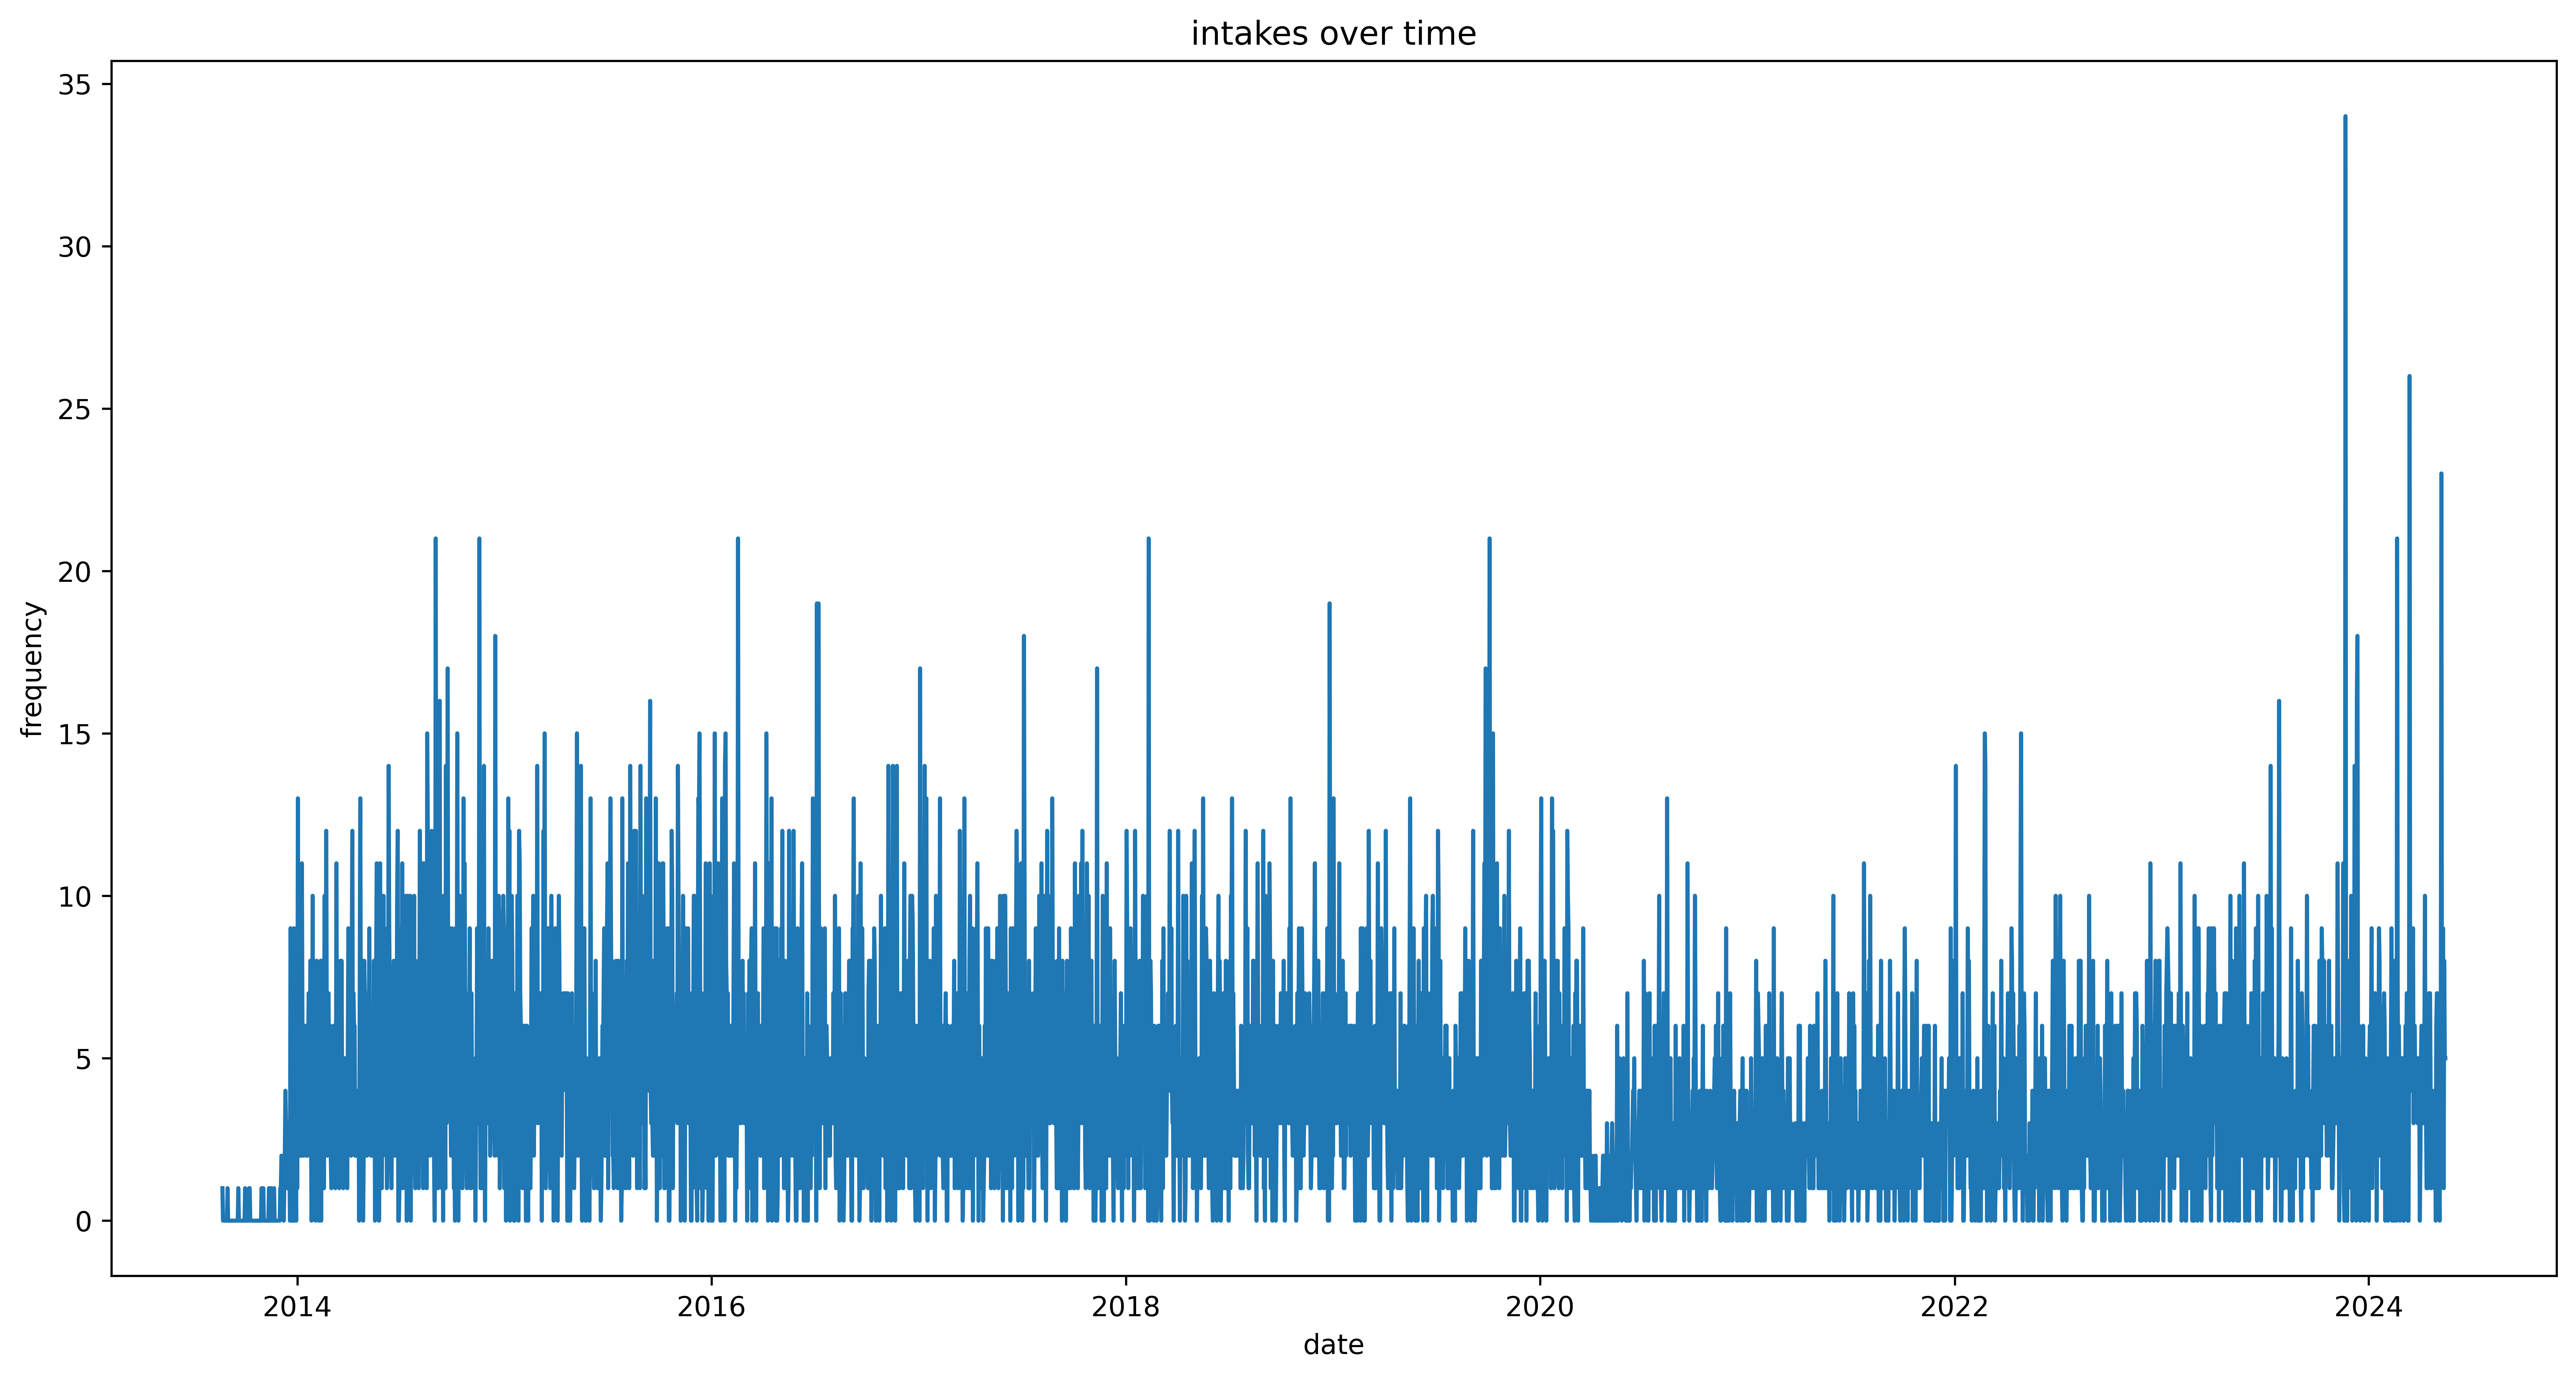

In [16]:
plt.figure(figsize = (16,8), dpi = 600)

plt.plot(sonoma_count["date"], sonoma_count["intakes"])

plt.title("intakes over time")

plt.xlabel("date")
plt.ylabel("frequency")

plt.show()

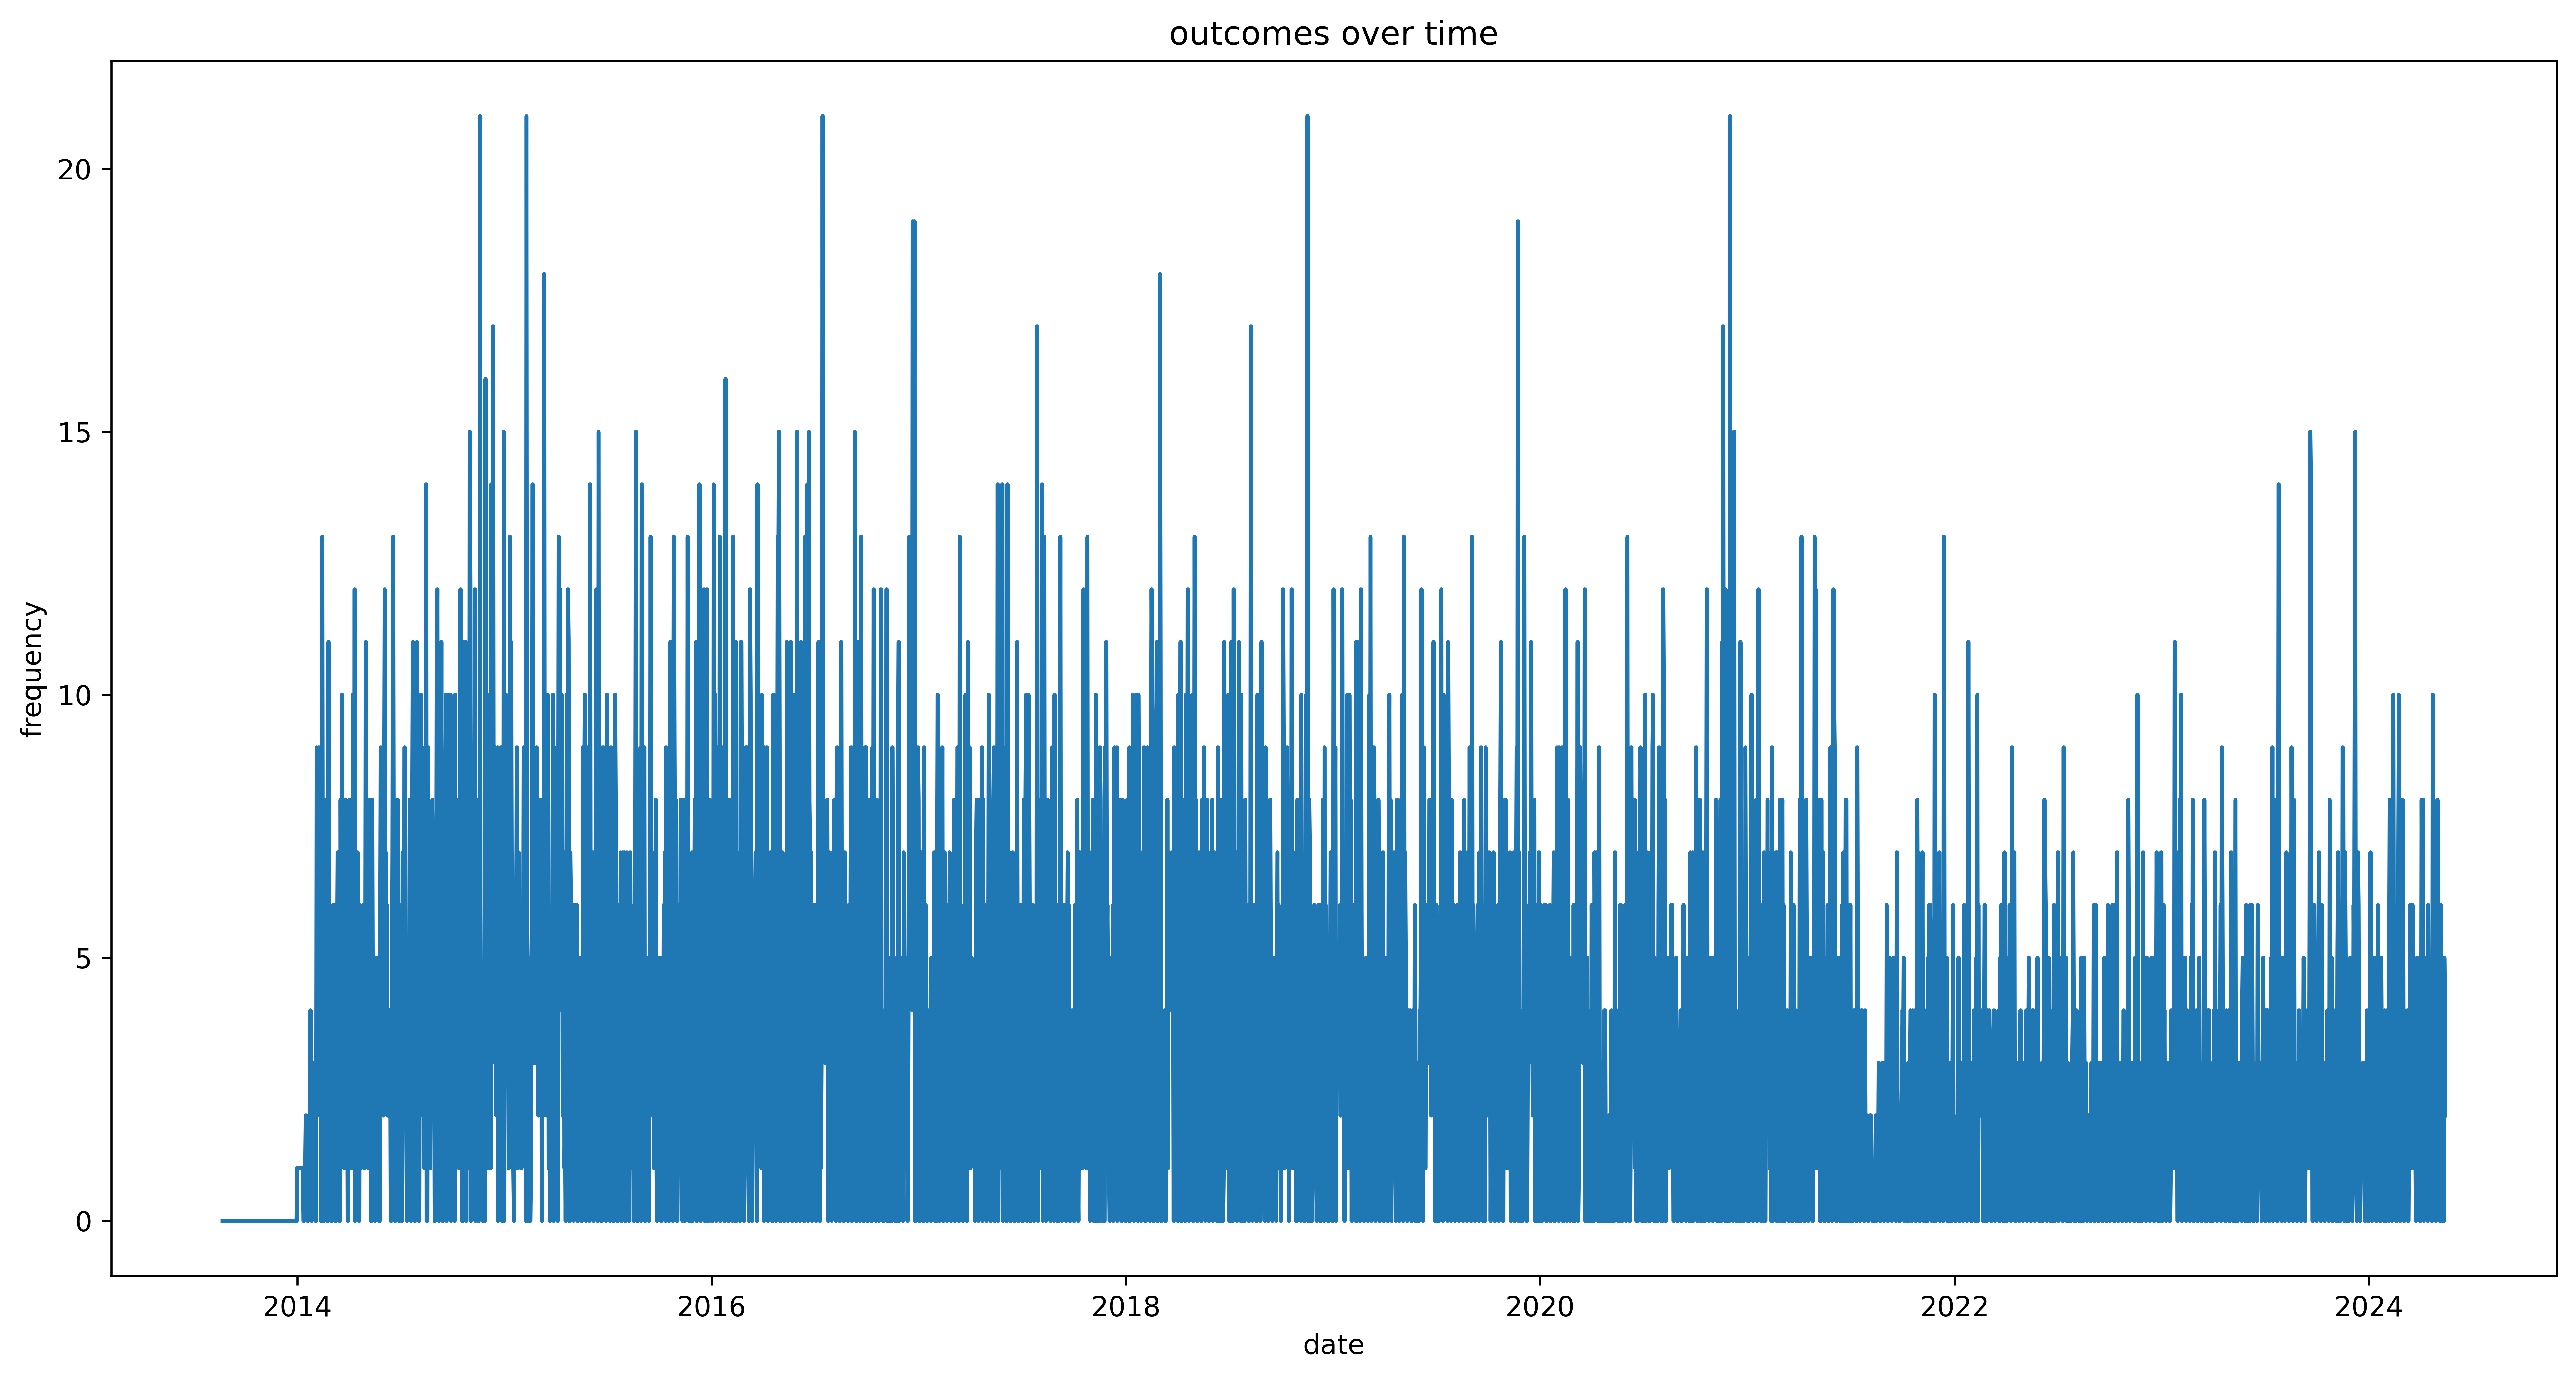

In [17]:
plt.figure(figsize = (16,8), dpi = 600)

plt.plot(sonoma_count["date"], sonoma_count["outcomes"])

plt.title("outcomes over time")

plt.xlabel("date")
plt.ylabel("frequency")

plt.show()

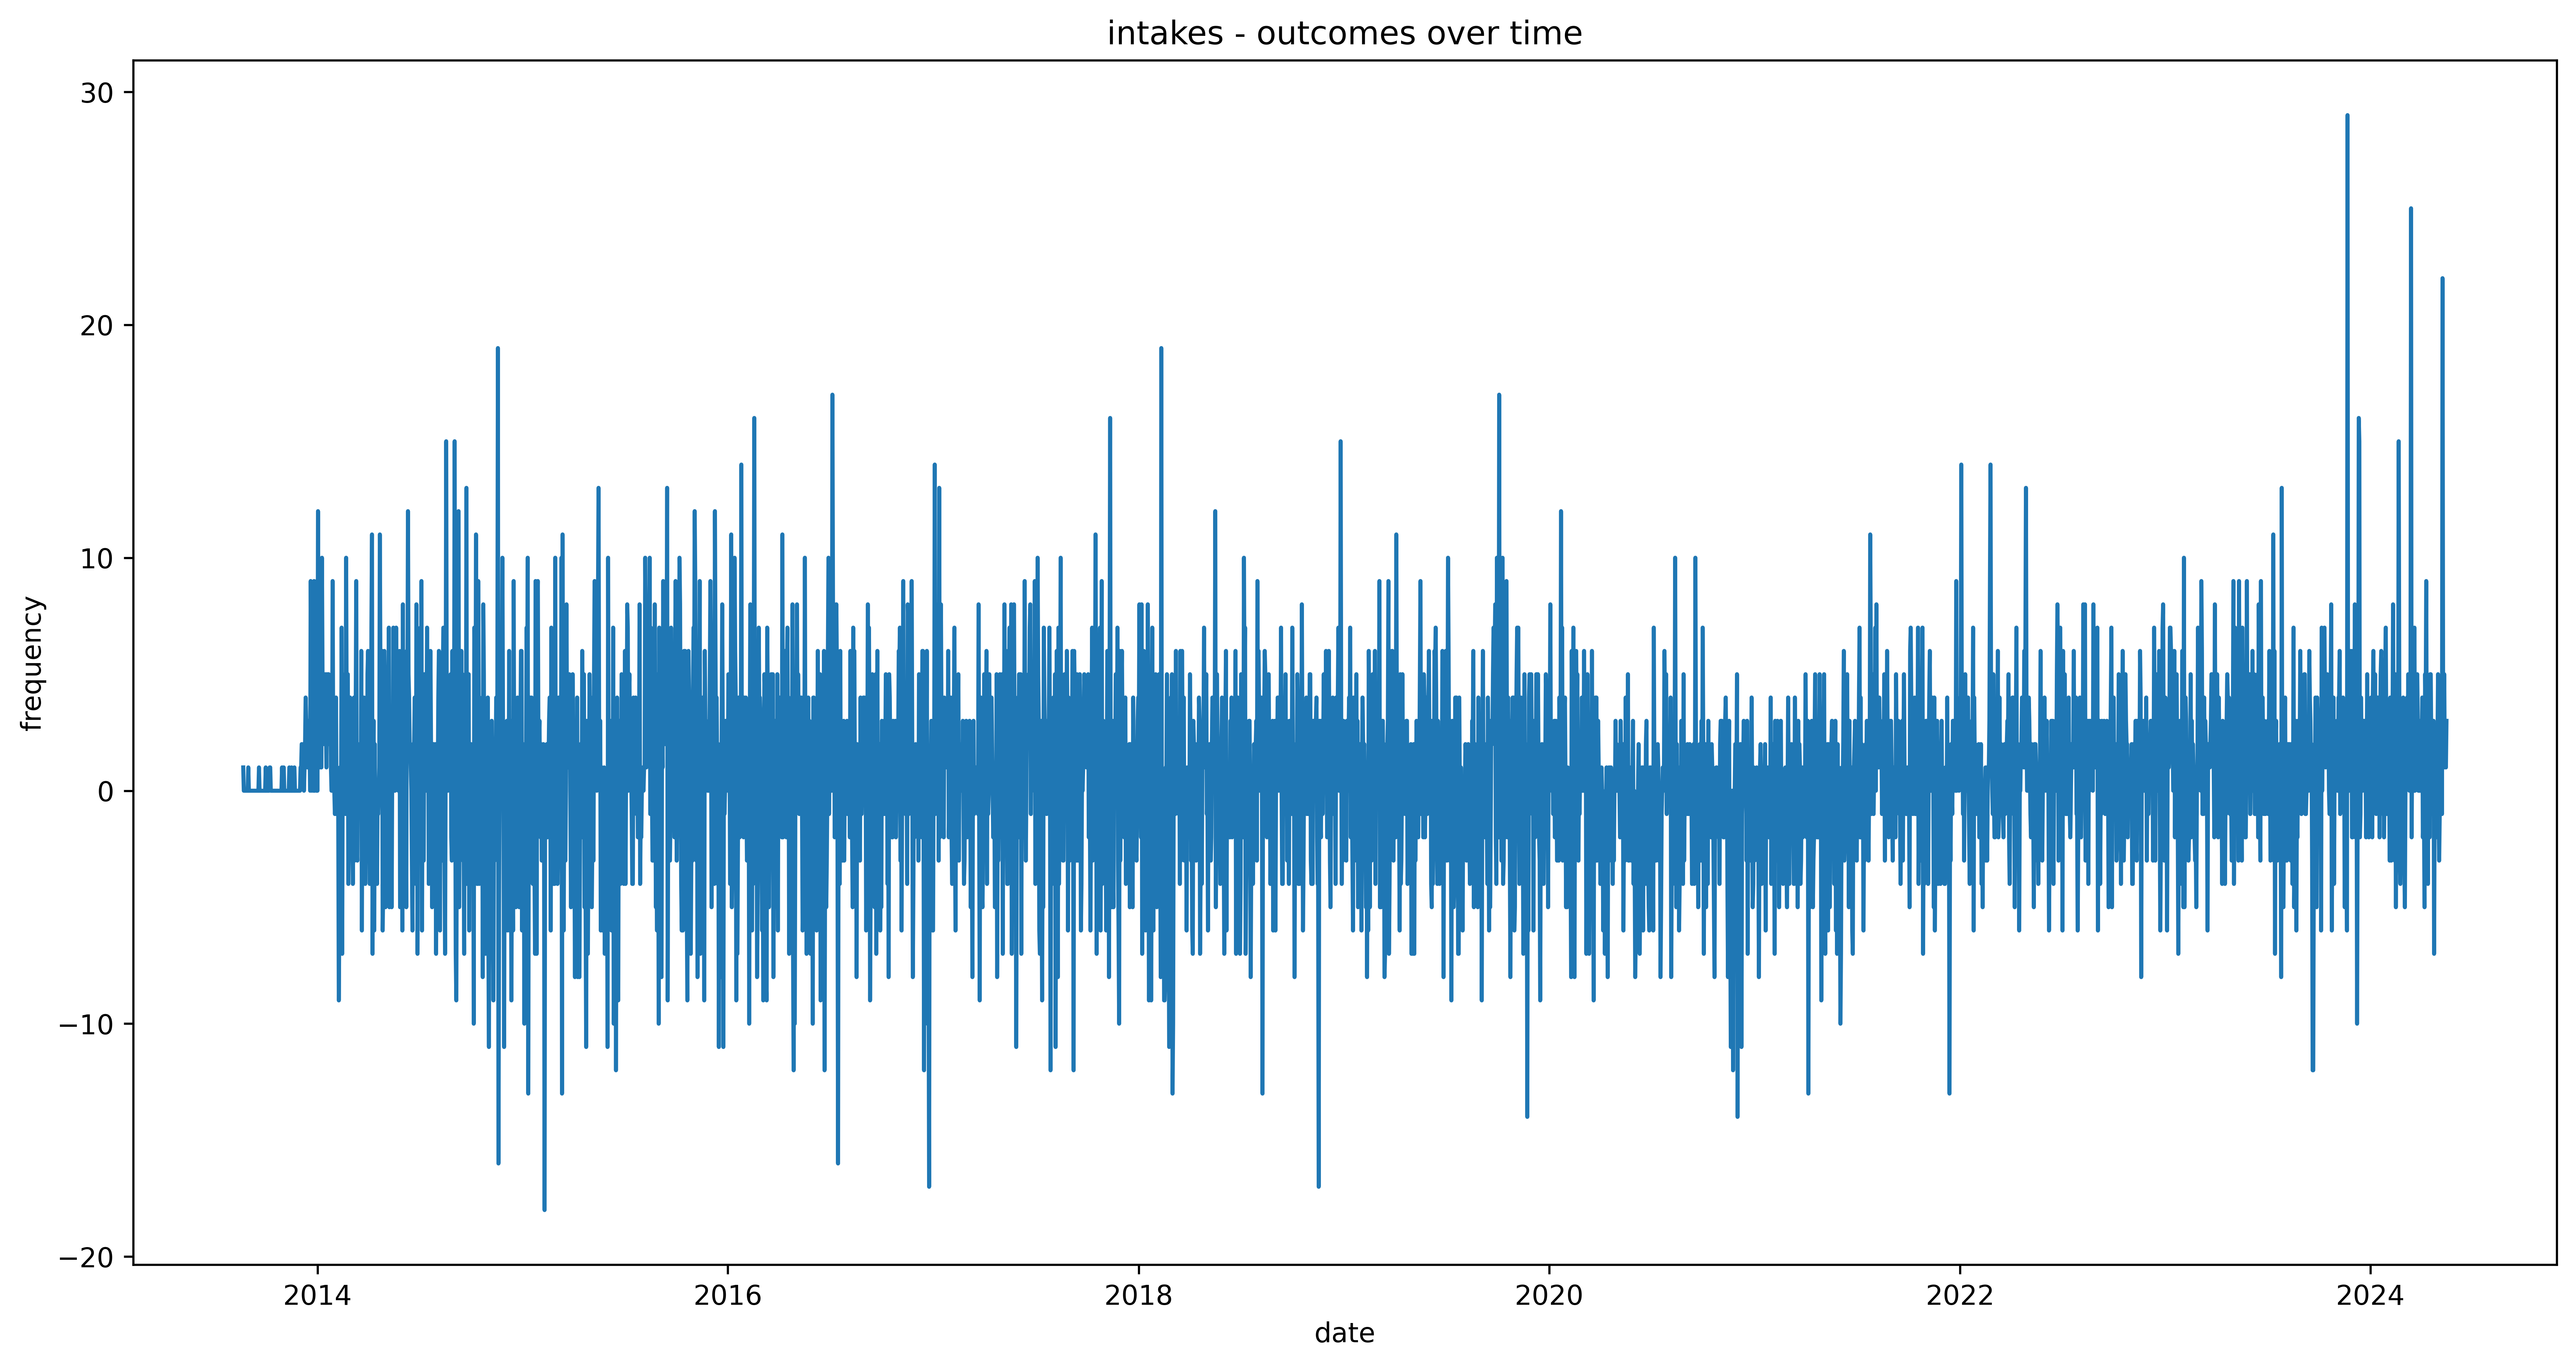

In [18]:
plt.figure(figsize = (16,8), dpi = 600)

plt.plot(sonoma_count["date"], sonoma_count["intakes"] - sonoma_count["outcomes"])

plt.title("intakes - outcomes over time")

plt.xlabel("date")
plt.ylabel("frequency")

plt.show()

In [20]:
sonoma_count

,date,intakes,outcomes,intake_stray_abandoned,intake_owner_surrender,intake_euthanasia,intake_public_assist,intake_other_i,outcome_euthanised,outcome_adoption,outcome_return_to_owner,outcome_unintended,outcome_other_o
0,2013-08-22,1,0,0,0,0,0,1,1,0,0,0,0
1,2013-08-23,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-08-24,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-08-25,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-08-26,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,2024-05-11,9,4,9,0,0,0,0,0,0,6,0,3
3916,2024-05-12,1,0,0,0,0,1,0,0,0,0,0,1
3917,2024-05-13,8,5,4,0,0,4,0,0,0,2,0,6
3918,2024-05-14,5,4,3,0,0,2,0,0,0,1,0,4


In [22]:
sonoma_count.to_csv("../main_data/locale_specific_data/sonoma_clean_data.csv")